## Lab 3 - Levenshtein distance and spelling corrections

In [1]:
import os
import time

import matplotlib.pyplot as plt
import Levenshtein

from collections import Counter

from spacy.lang.pl import Polish
from elasticsearch import Elasticsearch, helpers

nlp = Polish()

### Task 1

Note: using `tokenizer = Tokenizer(nlp.vocab)` and `tokenizer(text)` (as it is suggested here: https://spacy.io/api/tokenizer#init) instead of `nlp(text)` resulted in not separating e.g. `:` or `,` from words but kept them as a single token.

In [2]:
bills_dir = "../bills/"
bills_files = os.listdir(bills_dir)

tokens_per_file = {}

for file_path in [bills_dir + filename for filename in  bills_files]:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        tokens_per_file[file_path[9:]] = [token.text.lower() for token in nlp(text)]  # keep in lowercase
        
print(tokens_per_file['1993_599.txt'][:150])

['\n\n\n\n', 'dz', '.', 'u', '.', 'z', '1993', 'r', '.', 'nr', '129', ',', 'poz', '.', '599', '\n                                ', 'ustawa', '\n                        ', 'z', 'dnia', '9', 'grudnia', '1993', 'r', '.', '\n                                    \n             ', 'o', 'zmianie', 'ustawy', 'o', 'podatku', 'od', 'towarów', 'i', 'usług', '\n                        ', 'oraz', 'o', 'podatku', 'akcyzowym', '\n                                    \n                                    \n                                ', 'art', '.', '1', '.', '\n', 'w', 'ustawie', 'z', 'dnia', '8', 'stycznia', '1993', 'r', '.', 'o', 'podatku', 'od', 'towarów', 'i', 'usług', 'oraz', 'o', 'podatku', '\n', 'akcyzowym', '(', 'dz', '.', 'u', '.', 'nr', '11', ',', 'poz', '.', '50', 'i', 'nr', '28', ',', 'poz', '.', '127', ')', 'wprowadza', 'się', 'następujące', '\n', 'zmiany', ':', '\n ', '1', ')', 'w', 'art', '.', '3', ':', '\n    ', 'a', ')', 'dotychczasowa', 'treść', 'otrzymuje', 'oznaczenie', 'ust', '

### Task 2

Only counting the occurences, results still contain invalid characters.

In [3]:
frequency_dict_per_file = {bill: Counter(tokens) for bill, tokens in tokens_per_file.items()}
print(frequency_dict_per_file['1993_599.txt'].most_common(10))

[('|', 1634), ('-', 858), ('\n', 561), ('.', 497), ('   ', 485), (',', 306), ('w', 227), ('"', 183), (')', 179), ('        ', 170)]


### Task 3

In [4]:
global_frequency_dict = sum(frequency_dict_per_file.values(), Counter())
print(global_frequency_dict.most_common(10))

[('.', 441565), (',', 342866), ('w', 202063), ('\n', 184442), (')', 100755), ('i', 90324), ('art', 84246), ('z', 82814), ('1', 73637), ('-', 66220)]


### Task 4

`str.isalpha()` method already handles polish diacritics, no need for special handling of them.

In [5]:
"ąężźłśćóĄĘŻŹŁŚĆÓMbankPozdrawia".isalpha()

True

In [6]:
for token in list(global_frequency_dict.keys()):
    if len(token) < 2 or not token.isalpha():
        global_frequency_dict.pop(token)

print(global_frequency_dict.most_common(10))

[('art', 84246), ('do', 60977), ('ust', 53686), ('na', 50805), ('lub', 46100), ('się', 46066), ('poz', 45481), ('nr', 45157), ('oraz', 33654), ('mowa', 28891)]


### Task 5

Cannot just sort by number of occurences and name with `reverse=True` because occurences are sorted in descending order and the name in ascending order.

So: sort first by negated number of occurences (equals to sorting by the number as-is with `reverse=True` but doesn't set it for names) and by name in the second place.

In [7]:
# proof that it works
d = {'ac': 3, 'ab': 3, "d": 5, "g": 3, "a":1}
print("Expected: ['d', 'ab', 'ac', 'g', 'a']")
dx1 = sorted(list(d.keys()), key=lambda x: (d[x], x), reverse=True)
print("Bad: ", dx1)
dx2 = sorted(list(d.keys()), key=lambda x: (-d[x], x))
print("Good: ", dx2)

Expected: ['d', 'ab', 'ac', 'g', 'a']
Bad:  ['d', 'g', 'ac', 'ab', 'a']
Good:  ['d', 'ab', 'ac', 'g', 'a']


In [8]:
words_sorted = sorted(list(global_frequency_dict.keys()), key=lambda x: (-global_frequency_dict[x], x))
words_sorted_values = [global_frequency_dict[token] for token in words_sorted]
print(words_sorted[:20])
print(words_sorted_values[:20])

['art', 'do', 'ust', 'na', 'lub', 'się', 'poz', 'nr', 'oraz', 'mowa', 'nie', 'przez', 'pkt', 'dnia', 'których', 'od', 'po', 'jest', 'ustawy', 'może']
[84246, 60977, 53686, 50805, 46100, 46066, 45481, 45157, 33654, 28891, 23069, 21026, 19287, 18051, 17996, 16774, 13601, 13252, 13205, 12148]


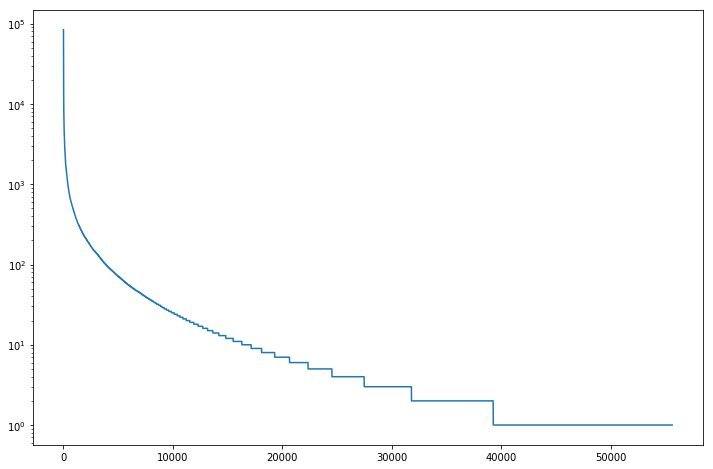

In [9]:
plt.figure(figsize=(12, 8))
plt.semilogy(range(1, len(words_sorted) + 1), words_sorted_values)
plt.show()

### Task 6

Form in the file is as follows:  
`base form of the word;conjugated form;gramatic markers`  

Example for some verb:  

<pre>
monitorować;monitorowali;verb:praet:pl:m1.p1:ter:imperf:refl.nonrefl  
monitorować;monitorowaliby;verb:pot:pl:m1.p1:ter:imperf:refl.nonrefl  
monitorować;monitorowalibyście;verb:pot:pl:m1.p1:sec:imperf:refl.nonrefl  
...  
monitorować;monitorowaną;ppas:sg:acc.inst:f:imperf:aff  
monitorować;<b>monitorować</b>;verb:inf:imperf:refl.nonrefl  
monitorować;monitorował;verb:praet:sg:m1.m2.m3:ter:imperf:refl.nonrefl  
...
</pre>

To get all the words it is needed to the string between semicolons in each line, since base form also exists in the second column.  
Also, there is no repetitions in this column because the third column contains markers for all contexts in which conjugated form can appear.

In [10]:
polish_words_file = '../polimorfololgik-2.1/polimorfologik-2.1.txt'
polimorfologik_words = []

with open(polish_words_file, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        polimorfologik_words.append(line.split(";")[1].lower()) # also keep in lowercase
    
print(polimorfologik_words[::100000])  # print some words

['aa', 'jadwisinie', 'podlewscy', 'adiabatyczne', 'beksom', 'chmielarstwa', 'dnieprzańska', 'dzierżawin', 'futorzan', 'huba', 'kaszkiecikowo', 'kronikalnym', 'maltretowałyby', 'nabawilibyśmy', 'nataska', 'nieburmistrzujące', 'nieemblematowemu', 'niekataralnościom', 'niemobbowanie', 'nieodwiązywaniu', 'niepokąsana', 'nieprześwitającego', 'niesamiutenieńkiej', 'nietopielne', 'niewspółmyśląca', 'niezaspokajającym', 'obarzaneczkowi', 'odmyszaj', 'opryskałeś', 'persimon', 'podszczuwają', 'porozjaśniałyby', 'pośmigałobym', 'przepchanych', 'przysłowioznawstwom', 'romantycznościach', 'rozwijalna', 'sklejajcie', 'stopniowałoś', 'tanieją', 'ufilozoficzniły', 'uwzięci', 'wranglerach', 'wymakali', 'wyżelowałoś', 'zamatowywałaby', 'zbieliłyśmy', 'zorzy', 'żelazokrzemu']


Skipping finding ALL the words that do not appear in dict on purpose. Checking for each of 55k words if it exists in list of 4.8m words takes too long.

In [11]:
# not_appearing_in_text = [word for word in words_sorted if word not in polimorfologik_words]
# print(len(not_appearing_in_text))

### Task 7

Top 30 words by occurences in texts that do not appear in dictionary.

In [12]:
missing_words_top_30 = []
i = 0

for word in words_sorted:
    if word not in polimorfologik_words:
        i += 1
        missing_words_top_30.append(word)
        
    if i == 30:
        break
        
print(missing_words_top_30)

['margin', 'późn', 'text', 'mso', 'face', 'panose', 'gmo', 'sa', 'iv', 'align', 'sww', 'justify', 'skw', 'div', 'line', 'ex', 'ike', 'autospace', 'none', 'vi', 'remediacji', 'vii', 'ure', 'family', 'uke', 'kn', 'cn', 'pkwiu', 'span', 'udt']


### Task 8

30 words that do not appear in dictionary and appeared in texts exactly 5 times.

In [13]:
missing_words_5_occurences = []
i = 0

for word in [word for word, value in global_frequency_dict.items() if value == 5]:
    if word not in polimorfologik_words:
        i += 1
        missing_words_5_occurences.append(word)
        
    if i == 30:
        break

print(missing_words_5_occurences)

['wapnio', 'instrumen', 'xxii', 'anonimizacji', 'próbobiorców', 'rci', 'ekofizjograficznych', 'naliczeń', 'betezda', 'swine', 'contagious', 'teryto', 'rialnego', 'szcze', 'jed', 'tów', 'niskomorfinowego', 'adopcyjnoopiekuńczych', 'agave', 'inci', 'nym', 'pełnoporcjowej', 'pełnoporcjowych', 'odgazowywacze', 'sprawdzeń', 'rr', 'izobutyl', 'cznika', 'zawart', 'ośc']


### Task 9

Tried also to ignore words not in polish dictionary but following code takes too long (stopped after 8+mins).

In [14]:
# correct_words_in_texts = [word for word in words_sorted[:words_sorted_values.index(5)] if word in polimorfologik_words]

Approach using Levenshtein distance and frequency dict:  
- checking the words that are present in texts, not necessarily correct (because of problem above, also maybe if some word appears very often in text it is valid in this context and shouldn't be discarded even if doesn't appear in polish dictionary)
- word must have appeared more than 5 times in texts (this spell checker will not suggest words that were rarely used and it may speed up the process).  

This returns the word with the smallest distance that appeared the most is all the bills (first alphabetically in case of multiple options).

In [15]:
start = time.time()
my_substitutions = {}
for word_to_replace in missing_words_5_occurences:
    substitution = None
    distance_best = 100
    for word in words_sorted[:words_sorted_values.index(5)]:
        dist = Levenshtein.distance(word_to_replace, word)
        if 0 < dist < distance_best: # > 0 not to return self
            distance_best = dist
            substitution = word
            if distance_best == 1:
                break # we can't get better than that
    my_substitutions[word_to_replace] = {'word': substitution, 'distance': distance_best}
end = time.time()
print("Took {} seconds.".format(end - start))

Took 0.3231673240661621 seconds.


In [16]:
for key, value in my_substitutions.items():
    print("Zamiana '{}' na '{}'\t- odległość Levenshteina = {}".format(key, value['word'], value['distance']))

Zamiana 'wapnio' na 'wapnia'	- odległość Levenshteina = 1
Zamiana 'instrumen' na 'instrument'	- odległość Levenshteina = 1
Zamiana 'xxii' na 'xii'	- odległość Levenshteina = 1
Zamiana 'anonimizacji' na 'mobilizacji'	- odległość Levenshteina = 4
Zamiana 'próbobiorców' na 'odbiorców'	- odległość Levenshteina = 5
Zamiana 'rci' na 'ci'	- odległość Levenshteina = 1
Zamiana 'ekofizjograficznych' na 'fizjograficznych'	- odległość Levenshteina = 3
Zamiana 'naliczeń' na 'odliczeń'	- odległość Levenshteina = 2
Zamiana 'betezda' na 'betel'	- odległość Levenshteina = 3
Zamiana 'swine' na 'swoje'	- odległość Levenshteina = 2
Zamiana 'contagious' na 'kontaktu'	- odległość Levenshteina = 5
Zamiana 'teryto' na 'tego'	- odległość Levenshteina = 3
Zamiana 'rialnego' na 'rolnego'	- odległość Levenshteina = 2
Zamiana 'szcze' na 'jeszcze'	- odległość Levenshteina = 2
Zamiana 'jed' na 'jej'	- odległość Levenshteina = 1
Zamiana 'tów' na 'ków'	- odległość Levenshteina = 1
Zamiana 'niskomorfinowego' na 'nieter

### Task 10

Here we load to ElasticSearch each word as a separate document and let it find the corrections.

In [17]:
es = Elasticsearch()
print(es.cat.plugins(params={'h': 'component,version,description'}))

index_config = {
    "analysis": {
        "analyzer": {
            "default": {
                "type": "custom",
                "tokenizer": "keyword" # no tokenization, no filters
            }
        }
    }
}

index_name = "polish_words"

if es.indices.exists(index=index_name): # in case of multiple runs, delete if index already exists
    es.indices.delete(index=index_name)

es.indices.create(index=index_name, body={"settings": index_config})

analysis-morfologik 7.9.2 Morfologik Polish Lemmatizer plugin for Elasticsearch



{'acknowledged': True, 'shards_acknowledged': True, 'index': 'polish_words'}

In [18]:
t = time.time()
bulk_query = [{'_index': index_name, 'word': word} for word in polimorfologik_words]
helpers.bulk(es, bulk_query)
print(time.time() - t, "seconds to load all")

435.35061979293823 seconds to load all


In [19]:
start = time.time()
es_substitutions = {}

for word in missing_words_5_occurences:
    res = es.search(index=index_name, body={"query": {"fuzzy": {"word": {"value": word, "fuzziness": 6}}}})
    es_substitutions[word] = [hit['_source']['word'] for hit in res['hits']['hits']]

end = time.time()
print("Took {} seconds.".format(end - start))

Took 2.7001304626464844 seconds.


In [21]:
for key, value in es_substitutions.items():
    print("Zamiana '{}' na: {}".format(key, value))

Zamiana 'wapnio' na: ['wapnic', 'wapnico', 'wapnie', 'wapnia', 'wapnic', 'wapnico', 'wapnie', 'wapnie', 'wapnij', 'wapniom']
Zamiana 'instrumen' na: ['instrument', 'instrumentu', 'instrumenty']
Zamiana 'xxii' na: ['ilii', 'apii', 'arii', 'avii', 'xeni', 'akii', 'alii', 'amii', 'arii', 'avii']
Zamiana 'anonimizacji' na: ['animizacji']
Zamiana 'próbobiorców' na: ['pracobiorców', 'prądobiorców']
Zamiana 'rci' na: ['irci', 'rai', 'rca', 'rai', 'roi', 'pci', 'raci', 'rai', 'rai', 'rei']
Zamiana 'ekofizjograficznych' na: []
Zamiana 'naliczeń' na: ['naliczek', 'naliczek', 'zaliczeń', 'haliczem', 'waliczek', 'baliczek', 'nacieczeń', 'naliczaj', 'naliczam', 'naliczać']
Zamiana 'betezda' na: ['bereda', 'bereza', 'betela', 'etezja']
Zamiana 'swine' na: ['seine', 'swing', 'sine', 'gwinea', 'gwinee', 'gwinei', 'gwineo', 'gwineą', 'gwineę', 'heine']
Zamiana 'contagious' na: ['contagiom', 'contagium']
Zamiana 'teryto' na: ['teryno', 'hetyto', 'tereso', 'tetydo', 'trytko', 'tryton', 'amryto', 'cerato'

### Task 11

#### The distribution of words in the corpus:
- Only one third of the words in corpus appeared more than 10 times.
- Additionally, there is very few words that appear really often, which was expected (some words like conjunctions or ones connected to files' subject just need to appear often in texts, but overall there isn't many distinct words like that).

#### The number of true misspellings vs. the number of unknown words:
- Looking at the top 30 words that are not in a polish dictionary (task 7) the most are clearly unknown words, e.g.: 
    - english words like: *'margin', 'text, 'justify', 'autospace', 'span'* (maybe they were in the metadata which appeared at the end of some files as it was not filtered out)
    - greek letters: *'iv', 'vi', 'vii'* (they were probably capitalized in text and it was clearer there)
- Considering 30 words that occured only 5 times it is much more interesting:
    - there are some obvious misspellings: *'zawart'* (missing last letter), *'adopcyjnoopiekuńczych'* (missing **-** between words)
    - still some greek and perhaps abbreviations: *'xxii'*, *'rr'*
    - words split on syllabels that were never connected together: *'wapnio'*(wy), *'instrumen'*(-talny), *'teryto'*, *'rialnego'*
    - *'izobutyl'* - I guess chemical terminology is not considered "polish"
    - no clue about these words: *'agave'*, *'swine'*, *'contagious'* (looks english again but in metadata such words appeared much more often)

#### The performance of your method compared to ElasticSearch:
- My solution: 0.32 seconds (base of 55k words)
- ElasticSearch: 2.70 seconds (looking over 4.8m words)
- It can be safely assumed that if both solutions would have similar size to work on, then ElasticSearch would be faster (it is now 10 times slower for 100 times more data to process)

#### The results provided by your method compared to ElasticSearch:
- My solution used solely words that appeared (more than 5 times) in analysed texts. Trying to remove words that are not in the dictionary would take to long to prepare the data. Additionally the result for each word was set to one ("best") candidate. 
- ElasticSearch's method was looking through all words in polish language (loaded all the words in reasonable time) but had no information of which words have appeared in texts or how often. It returned a few options to choose from, mostly having sense e.g.:  
- In both solutions Levenshtein distance was correctly minimized, but there was a difference in base of words used.
 
#### The validity of the obtained corrections:
- It is difficult to judge validity since many of the words swere not clear errors.
- My method never returned some non-polish words so not dropping them from the list didn't change anything in result (which is good).
- If there was less text to process my approach would not have any sense since 
- Because of the reduced number of words to choose sometimes I got clear misses as an answer (e.g.: *'odgazowywacze' - 'opracowywanie', 'pełnoporcjowej' - 'eksportowej'*).
- ElasticSearch had fuzziness limited not to return completely random words like in my solution (*'adopcyjnoopiekuńczych' - 'opiekuńczych'*)
- Sometimes ElasticSearch returned more reasonable substitution: *'odgazowywacze' -> ['odgazowywanie', 'odparowywacze', 'odgazowywane'] vs 'opracowywanie'*, mainly because my method most likely did not know about such words
- But sometimes less words proved to also be better: *'ekofizjograficznych' -> [] vs 'fizjograficznych'*
- The ideal solution would lie somewhere inbetween these two (maybe adding weights to indicate that options from texts are better when distances are similar).